In [25]:
#Cell 1 — Install Dependencies (run once)
!pip install torch torchvision matplotlib pandas tqdm scikit-learn


In [10]:
#Cell 2 — Import Libraries & Define Paths
import os
from pathlib import Path
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Paths — EDIT this to your dataset location
dataset_root = "dataset"
benign_root = Path(dataset_root) / "benign"
mal_root   = Path(dataset_root) / "malicious"

print("Benign folder exists:", benign_root.exists())
print("Malicious folder exists:", mal_root.exists())


Benign folder exists: True
Malicious folder exists: True


Total benign: 488
Total malicious: 611


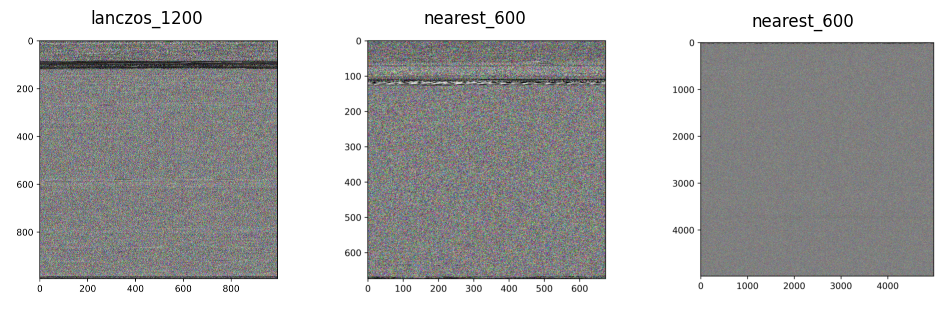

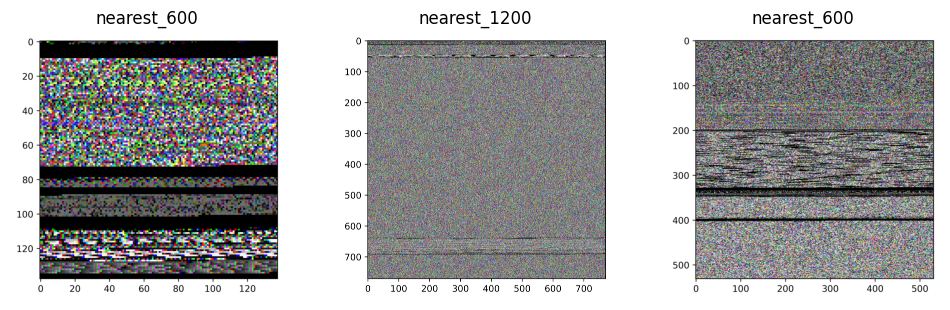

In [11]:
#Cell 3 — Count Images & Show Samples (Optional sanity check)
def count_images(root: Path):
    counts, total = {}, 0
    for sub in sorted([p for p in root.iterdir() if p.is_dir()]):
        imgs = list(sub.glob("*.png")) + list(sub.glob("*.jpg"))
        counts[sub.name] = len(imgs)
        total += len(imgs)
    return counts, total

def show_random_images(root: Path, n=3):
    imgs = []
    for sub in [p for p in root.iterdir() if p.is_dir()]:
        imgs += list(sub.glob("*.png"))
    if imgs:
        samples = random.sample(imgs, min(n, len(imgs)))
        plt.figure(figsize=(12,4))
        for i, s in enumerate(samples, 1):
            im = Image.open(s)
            plt.subplot(1, n, i)
            plt.imshow(im)
            plt.title(s.parent.name)
            plt.axis("off")
        plt.show()

ben_counts, ben_total = count_images(benign_root)
mal_counts, mal_total = count_images(mal_root)
print("Total benign:", ben_total)
print("Total malicious:", mal_total)
show_random_images(benign_root)
show_random_images(mal_root)


In [12]:
#Cell 4 — Prepare Dataset & Split
def gather_images(root: Path, label: int):
    all_imgs = []
    for sub in [p for p in root.iterdir() if p.is_dir()]:
        imgs = list(sub.glob("*.png")) + list(sub.glob("*.jpg"))
        all_imgs += [(str(p), label) for p in imgs]
    return all_imgs

benign_imgs = gather_images(benign_root, 0)
malicious_imgs = gather_images(mal_root, 1)
data = benign_imgs + malicious_imgs

train_data, test_data = train_test_split(data, test_size=0.3, stratify=[lbl for _, lbl in data], random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=[lbl for _, lbl in test_data], random_state=42)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Train: 769, Val: 165, Test: 165


In [ ]:
#Cell 5 — Define Transforms & Dataset Class
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class MalwareImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

train_dataset = MalwareImageDataset(train_data, train_transform)
val_dataset   = MalwareImageDataset(val_data, test_transform)
test_dataset  = MalwareImageDataset(test_data, test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)


In [26]:
#Cell 6 — Define a Stronger CNN Model (for better accuracy)
import torch.nn as nn

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = DeepCNN()
print(model)


DeepCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
#Cell 7 — Training Setup
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


In [17]:
#Cell 8 — Train the Model
num_epochs = 20  # increased epochs for better accuracy

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

scheduler.step()

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1/50: 100%|██████████| 25/25 [04:17<00:00, 10.30s/it]


Epoch 1/50 | Train Acc: 79.32% | Val Acc: 81.82% | Train Loss: 0.6032 | Val Loss: 0.4242


Epoch 2/50: 100%|██████████| 25/25 [05:17<00:00, 12.68s/it]


Epoch 2/50 | Train Acc: 83.75% | Val Acc: 84.85% | Train Loss: 0.3641 | Val Loss: 0.3729


Epoch 3/50: 100%|██████████| 25/25 [03:54<00:00,  9.38s/it]


Epoch 3/50 | Train Acc: 85.05% | Val Acc: 86.06% | Train Loss: 0.3605 | Val Loss: 0.3333


Epoch 4/50: 100%|██████████| 25/25 [06:19<00:00, 15.17s/it]


Epoch 4/50 | Train Acc: 88.04% | Val Acc: 88.48% | Train Loss: 0.3161 | Val Loss: 0.3493


Epoch 5/50: 100%|██████████| 25/25 [06:36<00:00, 15.85s/it]


Epoch 5/50 | Train Acc: 89.21% | Val Acc: 88.48% | Train Loss: 0.2667 | Val Loss: 0.3120


Epoch 6/50: 100%|██████████| 25/25 [06:14<00:00, 14.96s/it]


Epoch 6/50 | Train Acc: 88.95% | Val Acc: 87.27% | Train Loss: 0.2789 | Val Loss: 0.2592


Epoch 7/50: 100%|██████████| 25/25 [04:54<00:00, 11.77s/it]


Epoch 7/50 | Train Acc: 87.78% | Val Acc: 88.48% | Train Loss: 0.2702 | Val Loss: 0.3043


Epoch 8/50: 100%|██████████| 25/25 [03:23<00:00,  8.13s/it]


Epoch 8/50 | Train Acc: 89.86% | Val Acc: 89.70% | Train Loss: 0.3088 | Val Loss: 0.2202


Epoch 9/50: 100%|██████████| 25/25 [03:18<00:00,  7.94s/it]


Epoch 9/50 | Train Acc: 87.52% | Val Acc: 90.91% | Train Loss: 0.2951 | Val Loss: 0.2856


Epoch 10/50: 100%|██████████| 25/25 [03:38<00:00,  8.75s/it]


Epoch 10/50 | Train Acc: 88.69% | Val Acc: 91.52% | Train Loss: 0.2990 | Val Loss: 0.2463


Epoch 11/50: 100%|██████████| 25/25 [03:01<00:00,  7.28s/it]


Epoch 11/50 | Train Acc: 89.34% | Val Acc: 87.88% | Train Loss: 0.2656 | Val Loss: 0.2517


Epoch 12/50: 100%|██████████| 25/25 [03:02<00:00,  7.29s/it]


Epoch 12/50 | Train Acc: 90.12% | Val Acc: 90.91% | Train Loss: 0.2394 | Val Loss: 0.2308


Epoch 13/50: 100%|██████████| 25/25 [02:39<00:00,  6.40s/it]


Epoch 13/50 | Train Acc: 89.86% | Val Acc: 90.91% | Train Loss: 0.2251 | Val Loss: 0.2105


Epoch 14/50: 100%|██████████| 25/25 [03:00<00:00,  7.23s/it]


Epoch 14/50 | Train Acc: 90.64% | Val Acc: 91.52% | Train Loss: 0.2184 | Val Loss: 0.2115


Epoch 15/50: 100%|██████████| 25/25 [02:44<00:00,  6.60s/it]


Epoch 15/50 | Train Acc: 90.77% | Val Acc: 92.12% | Train Loss: 0.2292 | Val Loss: 0.2219


Epoch 16/50: 100%|██████████| 25/25 [02:52<00:00,  6.88s/it]


Epoch 16/50 | Train Acc: 91.16% | Val Acc: 92.12% | Train Loss: 0.2096 | Val Loss: 0.2035


Epoch 17/50: 100%|██████████| 25/25 [03:52<00:00,  9.28s/it]


Epoch 17/50 | Train Acc: 90.90% | Val Acc: 91.52% | Train Loss: 0.2155 | Val Loss: 0.2643


Epoch 18/50: 100%|██████████| 25/25 [03:18<00:00,  7.95s/it]


Epoch 18/50 | Train Acc: 90.77% | Val Acc: 92.73% | Train Loss: 0.1966 | Val Loss: 0.2036


Epoch 19/50: 100%|██████████| 25/25 [03:00<00:00,  7.24s/it]


Epoch 19/50 | Train Acc: 91.29% | Val Acc: 91.52% | Train Loss: 0.1971 | Val Loss: 0.1697


Epoch 20/50: 100%|██████████| 25/25 [02:52<00:00,  6.92s/it]


Epoch 20/50 | Train Acc: 91.16% | Val Acc: 92.12% | Train Loss: 0.2084 | Val Loss: 0.2537


Epoch 21/50: 100%|██████████| 25/25 [03:31<00:00,  8.46s/it]


Epoch 21/50 | Train Acc: 90.38% | Val Acc: 89.09% | Train Loss: 0.2393 | Val Loss: 0.5401


Epoch 22/50: 100%|██████████| 25/25 [03:18<00:00,  7.96s/it]


Epoch 22/50 | Train Acc: 90.12% | Val Acc: 92.12% | Train Loss: 0.2100 | Val Loss: 0.1790


Epoch 23/50: 100%|██████████| 25/25 [03:25<00:00,  8.21s/it]


Epoch 23/50 | Train Acc: 92.72% | Val Acc: 92.73% | Train Loss: 0.3889 | Val Loss: 0.1740


Epoch 24/50: 100%|██████████| 25/25 [03:36<00:00,  8.66s/it]


Epoch 24/50 | Train Acc: 90.90% | Val Acc: 92.73% | Train Loss: 0.2040 | Val Loss: 0.1758


Epoch 25/50: 100%|██████████| 25/25 [04:05<00:00,  9.82s/it]


Epoch 25/50 | Train Acc: 91.81% | Val Acc: 92.12% | Train Loss: 0.1809 | Val Loss: 0.2022


Epoch 26/50: 100%|██████████| 25/25 [03:48<00:00,  9.15s/it]


Epoch 26/50 | Train Acc: 91.68% | Val Acc: 92.73% | Train Loss: 0.1948 | Val Loss: 0.1749


Epoch 27/50: 100%|██████████| 25/25 [07:35<00:00, 18.23s/it]


Epoch 27/50 | Train Acc: 93.24% | Val Acc: 93.94% | Train Loss: 0.1734 | Val Loss: 0.1753


Epoch 28/50: 100%|██████████| 25/25 [02:04<00:00,  4.96s/it]


Epoch 28/50 | Train Acc: 92.72% | Val Acc: 94.55% | Train Loss: 0.1668 | Val Loss: 0.1386


Epoch 29/50: 100%|██████████| 25/25 [15:13<00:00, 36.56s/it] 


Epoch 29/50 | Train Acc: 93.11% | Val Acc: 94.55% | Train Loss: 0.1487 | Val Loss: 0.1300


Epoch 30/50: 100%|██████████| 25/25 [02:17<00:00,  5.51s/it]


Epoch 30/50 | Train Acc: 92.59% | Val Acc: 95.15% | Train Loss: 0.1632 | Val Loss: 0.1234


Epoch 31/50: 100%|██████████| 25/25 [03:22<00:00,  8.09s/it]


Epoch 31/50 | Train Acc: 93.11% | Val Acc: 94.55% | Train Loss: 0.3382 | Val Loss: 0.1133


Epoch 32/50: 100%|██████████| 25/25 [03:14<00:00,  7.77s/it]


Epoch 32/50 | Train Acc: 93.11% | Val Acc: 95.15% | Train Loss: 0.1716 | Val Loss: 0.1373


Epoch 33/50: 100%|██████████| 25/25 [03:24<00:00,  8.17s/it]


Epoch 33/50 | Train Acc: 92.72% | Val Acc: 95.76% | Train Loss: 0.2913 | Val Loss: 0.1212


Epoch 34/50: 100%|██████████| 25/25 [04:31<00:00, 10.85s/it]


Epoch 34/50 | Train Acc: 90.12% | Val Acc: 93.33% | Train Loss: 0.2644 | Val Loss: 0.1554


Epoch 35/50: 100%|██████████| 25/25 [05:41<00:00, 13.67s/it]


Epoch 35/50 | Train Acc: 92.20% | Val Acc: 94.55% | Train Loss: 0.1856 | Val Loss: 0.1780


Epoch 36/50: 100%|██████████| 25/25 [03:59<00:00,  9.57s/it]


Epoch 36/50 | Train Acc: 91.81% | Val Acc: 92.73% | Train Loss: 0.1854 | Val Loss: 0.1617


Epoch 37/50: 100%|██████████| 25/25 [55:10<00:00, 132.43s/it]  


Epoch 37/50 | Train Acc: 92.72% | Val Acc: 93.33% | Train Loss: 0.1814 | Val Loss: 0.1516


Epoch 38/50: 100%|██████████| 25/25 [05:46<00:00, 13.86s/it]


Epoch 38/50 | Train Acc: 92.72% | Val Acc: 93.94% | Train Loss: 0.1679 | Val Loss: 0.1524


Epoch 39/50: 100%|██████████| 25/25 [05:52<00:00, 14.09s/it]


Epoch 39/50 | Train Acc: 92.46% | Val Acc: 93.33% | Train Loss: 0.1798 | Val Loss: 0.1515


Epoch 40/50: 100%|██████████| 25/25 [01:59<00:00,  4.79s/it]


Epoch 40/50 | Train Acc: 91.68% | Val Acc: 93.94% | Train Loss: 0.1871 | Val Loss: 0.1457


Epoch 41/50: 100%|██████████| 25/25 [02:25<00:00,  5.80s/it]


Epoch 41/50 | Train Acc: 91.94% | Val Acc: 93.94% | Train Loss: 0.1832 | Val Loss: 0.1355


Epoch 42/50: 100%|██████████| 25/25 [02:31<00:00,  6.05s/it]


Epoch 42/50 | Train Acc: 92.07% | Val Acc: 93.33% | Train Loss: 0.1746 | Val Loss: 0.1479


Epoch 43/50: 100%|██████████| 25/25 [02:27<00:00,  5.90s/it]


Epoch 43/50 | Train Acc: 92.98% | Val Acc: 93.94% | Train Loss: 0.1687 | Val Loss: 0.1431


Epoch 44/50: 100%|██████████| 25/25 [02:00<00:00,  4.81s/it]


Epoch 44/50 | Train Acc: 92.98% | Val Acc: 93.94% | Train Loss: 0.1667 | Val Loss: 0.1336


Epoch 45/50: 100%|██████████| 25/25 [02:21<00:00,  5.66s/it]


Epoch 45/50 | Train Acc: 93.11% | Val Acc: 93.94% | Train Loss: 0.1703 | Val Loss: 0.1424


Epoch 46/50: 100%|██████████| 25/25 [02:31<00:00,  6.06s/it]


Epoch 46/50 | Train Acc: 93.37% | Val Acc: 93.94% | Train Loss: 0.1640 | Val Loss: 0.1452


Epoch 47/50: 100%|██████████| 25/25 [02:33<00:00,  6.14s/it]


Epoch 47/50 | Train Acc: 92.20% | Val Acc: 93.94% | Train Loss: 0.1742 | Val Loss: 0.1383


Epoch 48/50: 100%|██████████| 25/25 [01:58<00:00,  4.74s/it]


Epoch 48/50 | Train Acc: 93.24% | Val Acc: 93.94% | Train Loss: 0.4041 | Val Loss: 0.1389


Epoch 49/50: 100%|██████████| 25/25 [01:57<00:00,  4.72s/it]


Epoch 49/50 | Train Acc: 92.46% | Val Acc: 93.94% | Train Loss: 0.1800 | Val Loss: 0.1439


Epoch 50/50: 100%|██████████| 25/25 [02:06<00:00,  5.06s/it]


Epoch 50/50 | Train Acc: 92.07% | Val Acc: 95.15% | Train Loss: 0.5197 | Val Loss: 0.1473


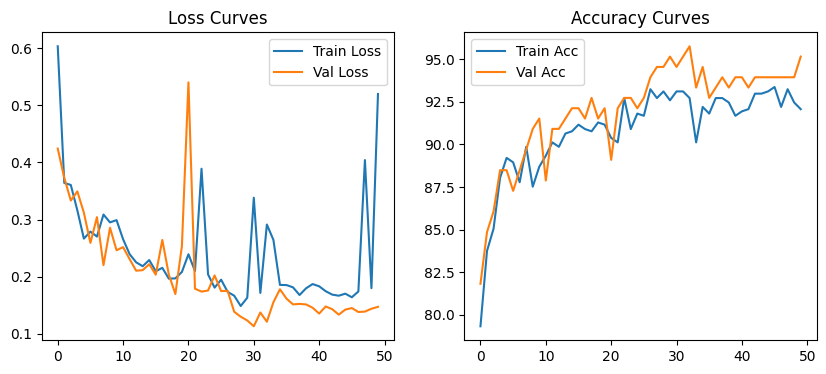

In [18]:
#Cell 9 — Plot Accuracy & Loss Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curves")

plt.show()


✅ Test Accuracy: 96.97%


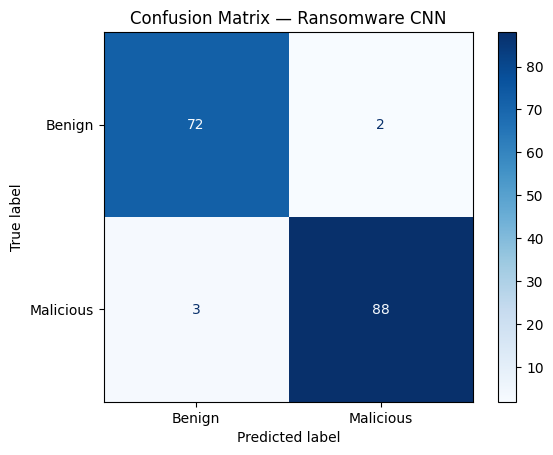

💾 Model saved as 'ransomware_cnn_model.pth'


In [19]:
#Cell 10 — Evaluate on Test Set + Save Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
test_correct, test_total = 0, 0
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"✅ Test Accuracy: {test_acc:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Ransomware CNN")
plt.show()

torch.save(model.state_dict(), "ransomware_cnn_model.pth")
print("💾 Model saved as 'ransomware_cnn_model.pth'")


✅ Test Accuracy: 96.97%

📊 Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.97      0.97        74
   Malicious       0.98      0.97      0.97        91

    accuracy                           0.97       165
   macro avg       0.97      0.97      0.97       165
weighted avg       0.97      0.97      0.97       165



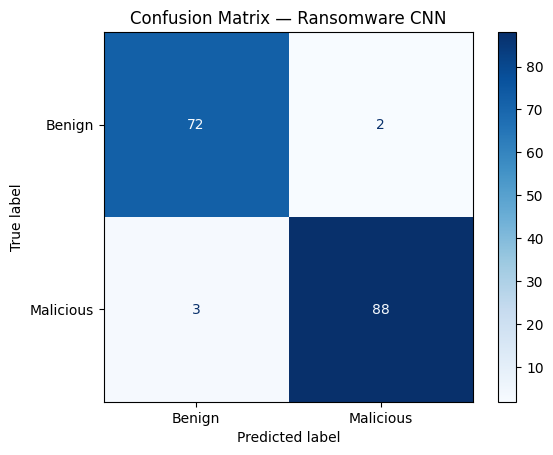

In [20]:
#Cell 11 Occuracy Checking
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch

# --- Evaluation mode ---
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# --- Metrics ---
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {acc * 100:.2f}%\n")

# Detailed report (Precision, Recall, F1-score, Support)

print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Benign", "Malicious"]))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Ransomware CNN")
plt.show()


In [2]:
#Cell 12 Testing Code
from PIL import Image
import torchvision.transforms as transforms
import torch

# --- Load the trained model ---
model.eval()
model.load_state_dict(torch.load("model/ransomware_cnn_model.pth", map_location=device))
model.to(device)

# --- Define the same preprocessing used for training ---
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Function to test a single image ---
def predict_image(image_path):
    img = Image.open(image_path).convert("L")
    img_tensor = transform(img).unsqueeze(0).to(device)  # add batch dimension

    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)

    label = "Benign" if pred.item() == 0 else "Malicious"
    return label

# --- Example usage ---
# Change this path to any image from your dataset (benign or malicious)
test_image_path = "samples/test1.png"
result = predict_image(test_image_path)
print(f"🔍 The model predicts: **{result}**")


NameError: name 'model' is not defined